In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings; warnings.simplefilter('ignore')

In [145]:
file = pd.read_csv('results-survey150419.csv')
print("The total number of responses received is {}.\n".format(len(file)))
file = file.drop(file.columns[[range(0,6)]], axis=1)
file.rename(columns={file.columns[0]: 'Country', file.columns[1]: 'Business Category'\
                   , file.columns[2]: 'Business Category [Business Category - Other]'\
                   , file.columns[12]: 'Campaign Run'}, inplace=True)
file['Country'].replace(np.nan, "Other", inplace=True)

#Renaming Business Categories
file.replace(('Regulator/Government Agency', 'Internet eXchange Point (IXP)', 
                 'End-user (Home/Mobile broadband)', 'Academic Institution', 'Academic network (NRENs)',
                 'Internet Service Provider (ISP)', 'Telecom (Mobile) Operator','Wireless network',
                'Enterprise Network','ccTLD/DNS Operator','Community Network','Datacentre', 'Cable Operator'),
                ('Regulator/Govt', 'IXP', 'End User', 'Academic Network', 'Academic Network','ISP', 'ISP',
                 'ISP', 'Other', 'Other', 'Other', 'Other', 'Other'), 
                inplace=True)

The total number of responses received is 243.



In [4]:
#Elimate respondents with no single measurement answer.
df = file
df.dropna(subset=['Campaign Run'], inplace=True)
print("First Cleaning: Elimating responses with no single measurement answer")
print("Total Number of responses: {}".format(len(df)))
print("Number of countries that responded: {}".format(len(df['Country'].value_counts())-1))#minus 1 of 'Other'
print("Responses with no country specified: {}\n".format(len(df[df['Country'] == "Other"])))

#Dropping all responses with less than 80% completion rate
df = df.dropna(thresh=df.shape[1]-80) #drop rows where NaN values constituate up to 92 of the total entries
print("Second Cleaning: Eliminate respondents with less than 80% completion")
total_responses = len(df)
print("Total Number of responses: {}".format(total_responses))
print("Number of countries that responded: {}".format(len(df['Country'].value_counts())-1))#minus 1 of 'Other'
print("Responses with no country specified: {}\n".format(len(df[df['Country'] == "Other"])))

#Businesses that run measurement campaign
runm = len(df[['Business Category', 'Campaign Run']][df['Campaign Run']=="Yes"])
runperc = round(runm/len(df)*100, 2)
print("Total number of businesses than run some measurement campaign: {} or {}% of all responses"\
      .format(runm, runperc))

#Businesses that collect some measurement data
df.rename(columns={'8._Do_you_collect_data_for_the_metrics_selected_in_the_previous_question?\n\t\n\n\n\t\xa0':\
                   'Businesses Collecting Data'}, inplace=True)
mdata = len(df[['Business Category', 'Businesses Collecting Data']][df['Businesses Collecting Data']=="Yes"])
mdataper = round(mdata/len(df)*100, 2)
print("Total number of businesses that collect some measurement data: {} or {}% of all responses"\
      .format(mdata, mdataper))

#Number of Response by category
df1 = df.set_index('Business Category')
count = {}
for i in df1.index.unique().tolist():
    name = str(i)
    length = len(df1.loc[name])
    count.update({name:length })
count

First Cleaning: Elimating responses with no single measurement answer
Total Number of responses: 162
Number of countries that responded: 35
Responses with no country specified: 10

Second Cleaning: Eliminate respondents with less than 80% completion
Total Number of responses: 123
Number of countries that responded: 34
Responses with no country specified: 4

Total number of businesses than run some measurement campaign: 31 or 25.2% of all responses
Total number of businesses that collect some measurement data: 68 or 55.28% of all responses


{'Other': 22,
 'End User': 11,
 'Academic Network': 34,
 'Regulator/Govt': 5,
 'IXP': 8,
 'ISP': 35,
 'Civil society': 8}

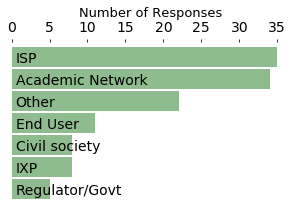

In [146]:
#Number of responses by business category; and whether they run measurement campaign
def measurement_campaign():
    runcamp = df[['Business Category', 'Campaign Run']][df['Campaign Run']=="Yes"]
    runcamp = runcamp.groupby('Business Category').agg({'Campaign Run': 'count'})
    responses = pd.Series(count)
    final = pd.concat([responses,runcamp], axis=1, join='outer')
    final.fillna(0, inplace=True)
    final['Campaign Run'] = final['Campaign Run'].astype(int)
    final.rename(columns={final.columns[0]: 'Total Number of Responses',
                 'Campaign Run':'Number Running Campaign'}, inplace=True)
    final = final.sort_values(by = ['Total Number of Responses'], ascending=False)
    final['% Running Campaign'] = round((final['Number Running Campaign'\
                                              ]/final['Total Number of Responses'])*100, 2)
    
    final_plot = final['Total Number of Responses']
    final_plot = final_plot.iloc[::-1] #Reversing the index to have the higher values on top
    
    ax = final_plot.plot(kind='barh', width=.9, figsize=(5,3), color='darkseagreen')
    bars = ax.patches
    
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.yaxis.tick_right()
    ax.tick_params(axis="y", which='major', length=0)
    ax.tick_params(axis="y",direction="in", pad=-275)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Number of Responses', fontdict={'fontsize': 13})
    ax.set_xticks([0,5,10,15,20,25,30,35])
    plt.savefig('figures/network_responses.pdf', bbox_inches = 'tight')
    plt.show()
    return
measurement_campaign()

In [147]:
#Whether a business category has run some measurement or not
def measurement_data():
    mdata = df[['Business Category', 'Businesses Collecting Data']][df['Businesses Collecting Data']=="Yes"]
    mdata = mdata.groupby('Business Category').agg({'Businesses Collecting Data': 'count'})
    responses = pd.Series(count)
    final = pd.concat([responses, mdata], axis=1, join='outer')
    final.rename(columns={final.columns[0]: 'Total Number of Responses'}, inplace=True)    
    final['% Running Measurement'] = round((final['Businesses Collecting Data']\
                                            /final['Total Number of Responses'])*100, 2)
    final = final.sort_values(by = ['Total Number of Responses'], ascending=False)
    return final
measurement_data()

,Total Number of Responses,Businesses Collecting Data,% Running Measurement
ISP,35,24,68.57
Academic Network,34,14,41.18
Other,22,15,68.18
End User,11,3,27.27
Civil society,8,6,75.00
IXP,8,4,50.00
Regulator/Govt,5,2,40.00


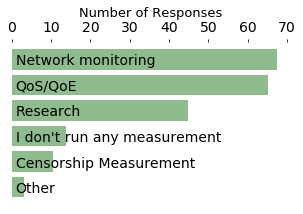

In [149]:
#Purpose of Running Business
def purpose_of_measurement():
    reasons =['Business Category',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Network_monitoring]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Quality_of_Service_(QoS)/Quality_of_Experience_(QoE)]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Research]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Censorship_Measurement]',
              "6._Please_state_your_main_purpose_for_running_network_measurements?_[I_don't_run_any_measurement]",
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]']

    df2 = df[reasons]
    freq = []
    purpose = []
    other = 0
    for col in df2.columns[1:]:
        column = str(col)
        if col == "6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]":
            new_purpose = tuple(df2[col].dropna().unique())
            for purp in new_purpose:
                value = len(df2[['Business Category', column]][df2[column]==str(purp)])
                other += value
            perc = (other/len(df2)*100)
            freq.append(perc)
            purpose.append("Other")
        else:    
            value = len(df2[['Business Category', column]][df2[column]=="Yes"])
            perc = (value/len(df2)*100)
            freq.append(perc)
            ntype = col.split('[')[1].split(']')[0]
            if ntype == "Quality_of_Service_(QoS)/Quality_of_Experience_(QoE)":
                ntype="QoS/QoE"
            purpose.append(ntype)
            
    final = dict(zip(purpose, freq)) #Creating dictionary based on the values in the two lists
    final = {k: v for k, v in sorted(final.items(), key=lambda x: x[1])} #Sorting dict by values

    fig, ax = plt.subplots(figsize=(5,3))
    final = {x.replace('_', ' '): v for x, v in final.items()}
    
    bars = plt.barh(*zip(*final.items()), height=.8, color='darkseagreen')
    
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.yaxis.tick_right()
    ax.tick_params(axis="y", which='major', length=0)
    ax.tick_params(axis="y",direction="in", pad=-275)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Number of Responses', fontdict={'fontsize': 13})
    ax.set_xticks([0,10,20,30,40,50,60,70])
    
    plt.savefig('figures/purpose.pdf', bbox_inches = 'tight')
    plt.show()

    return 
purpose_of_measurement()


Which of these performance indicators/metrics are important for your organisation/network?




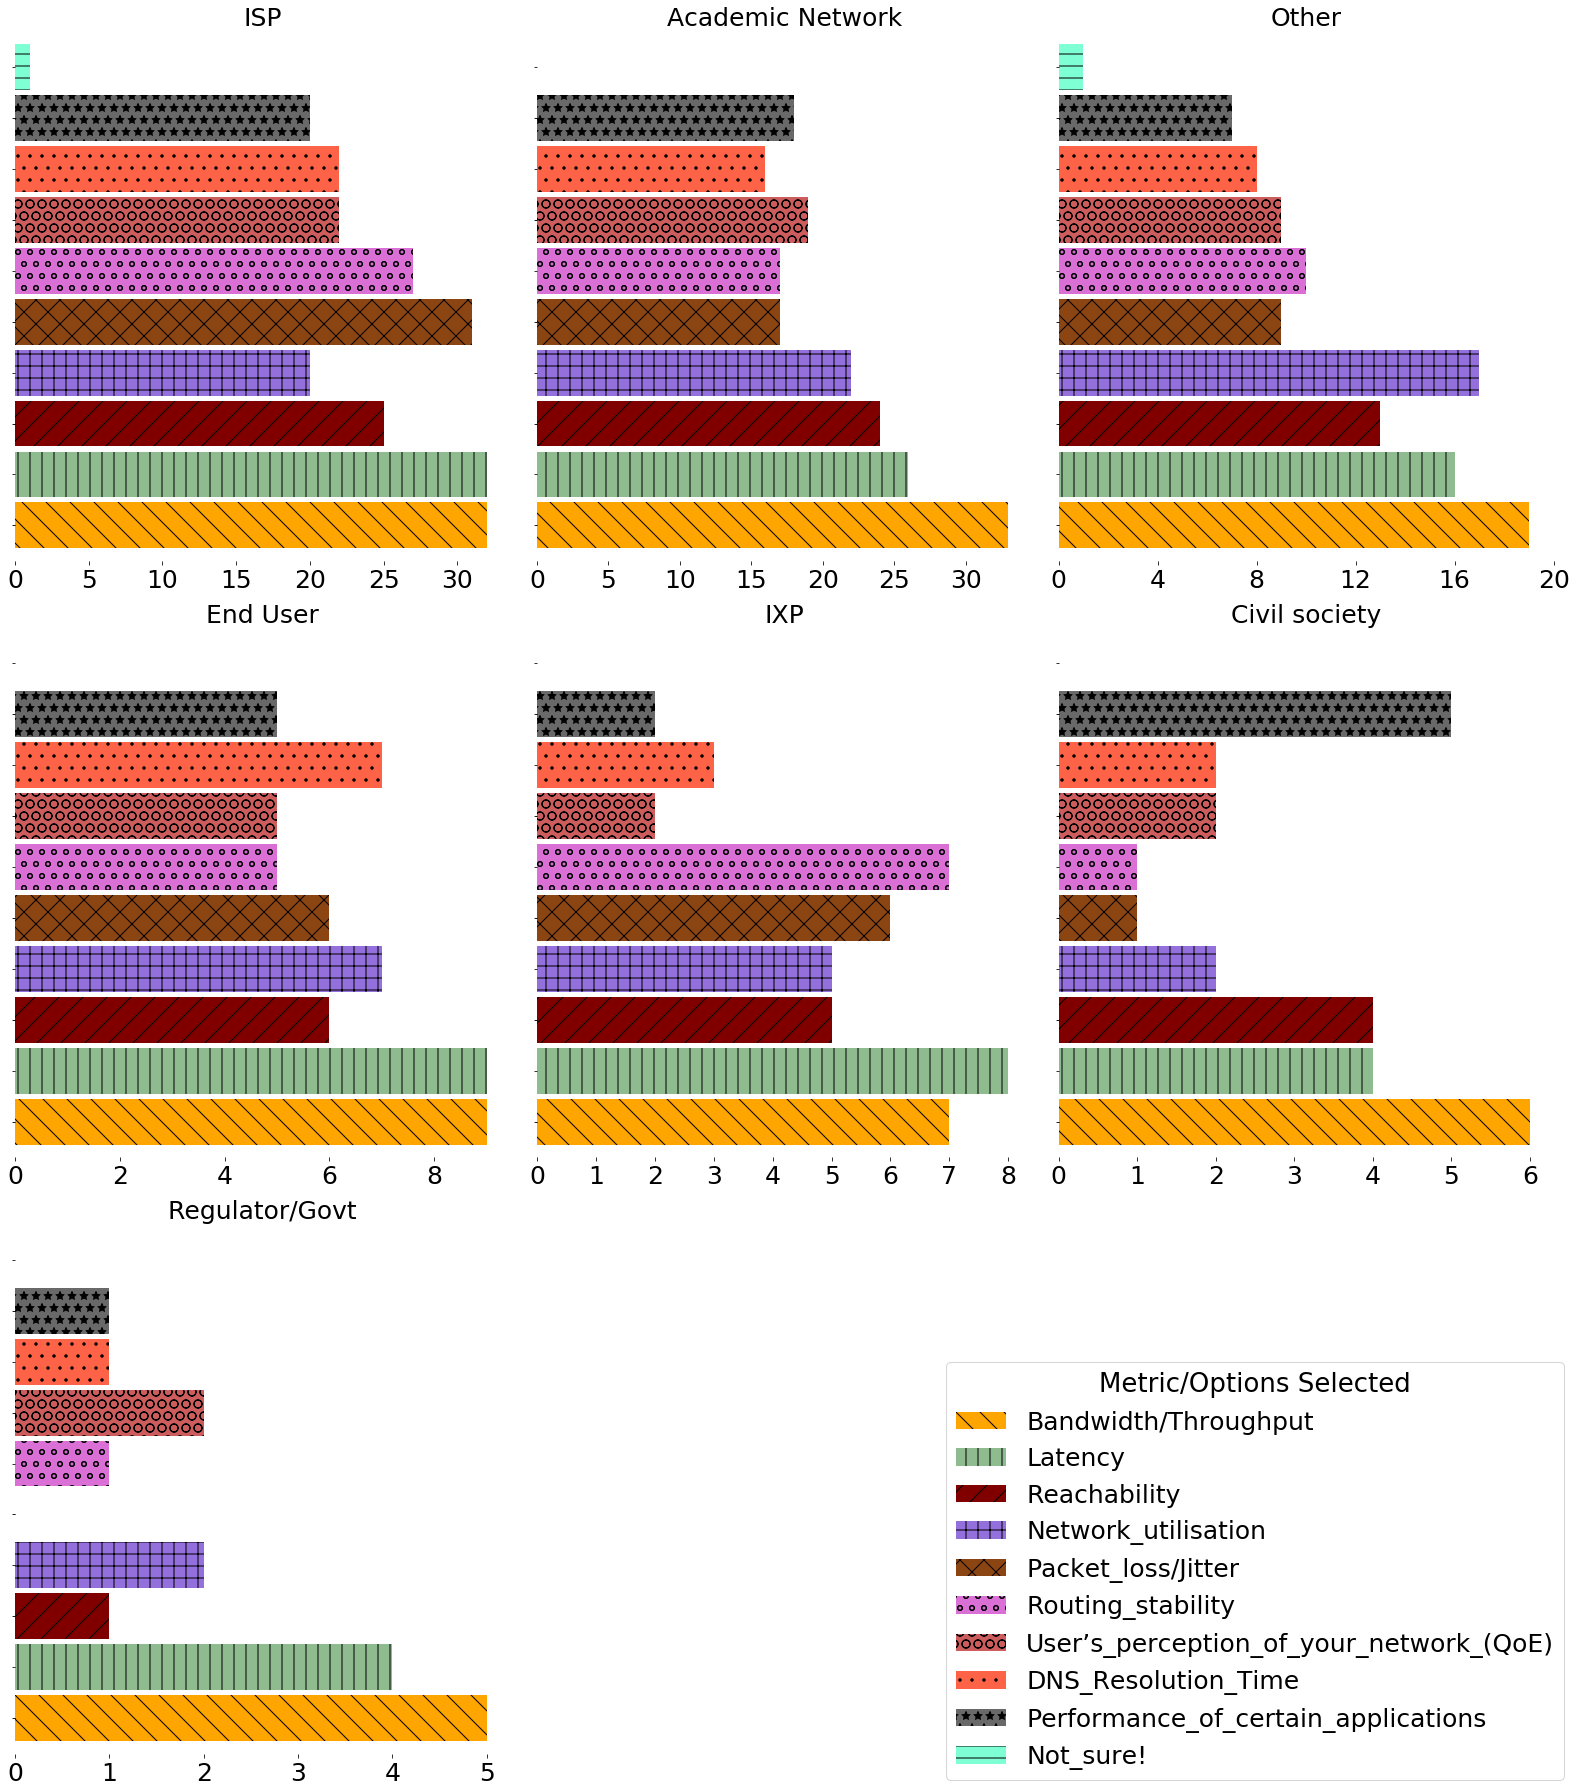

In [150]:
#The popular metrics
def metrics():
    metrics_list =['Business Category',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Latency]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Bandwidth/Throughput]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Packet_loss/Jitter]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[User’s_perception_of_your_network_(QoE)]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Reachability]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Routing_stability]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Performance_of_certain_applications_(Youtube,_Facebook,_etc)]]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Network_utilisation]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[DNS_Resolution_Time]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Not_sure!]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Other]',]
    
    df1 = df[metrics_list]
    df1.replace(('Yes', 'No'), (1, 0), inplace=True)
    df1.set_index('Business Category', inplace=True)
    
   
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        if name == "Performance_of_certain_applications_(Youtube,_Facebook,_etc)":
            name=name.split("(")[0][:-1]
        df1.rename(columns={col:name}, inplace=True)
    
    df1.drop(['Other'], axis=1, inplace=True)
    df1 = df1.groupby(level=0, as_index=True).sum()
    
    df1.loc['Total',:]= df1.sum(axis=0)
    df1=df1[df1.iloc[-1,:].sort_values(ascending=False).index]
    df1['Total'] = df1.sum(axis=1)
    df1 = df1.sort_values(by='Total', ascending=False)
    
    i = j = roundcounter = 0
    patterns = ['\\', '|', '/', '+', 'x', 'o', 'O', '.', '*', '-']
    color=['orange', 'darkseagreen', 'maroon', 'mediumpurple', 'saddlebrown', 'orchid', 'indianred',
          'tomato', 'dimgrey', 'aquamarine'] 
    
    fig, axes = plt.subplots(3,3, sharex=False, sharey=True)
    print("\nWhich of these performance indicators/metrics are important for your organisation/network?\n\n")
    
    #Plot the graphs
    for col in df1[1:].index:
        bars = df1.loc[col].drop(['Total']).plot.barh(width=.9, figsize=(22, 25), color=color, ax=axes[i, j])
        
        for tick in axes[i, j].xaxis.get_major_ticks():
                tick.label.set_fontsize(25)
        
        axes[i, j].set_title(df1.loc[col].name, fontdict={'fontsize': 25, 'fontweight': 'medium'})
        axes[i, j].get_yaxis().set_ticklabels([])
        for spine in axes[i, j].spines:
            axes[i, j].spines[spine].set_visible(False)

        for bar, pattern in zip(bars.patches, patterns):        
            bar.set_hatch(pattern)
  
        if j==2: 
            if roundcounter==0:
                roundcounter+=1
                i=1
                j=0
            elif roundcounter==1:
                roundcounter+=1
                j=0
                i=2
            elif roundcounter==2:
                i=2
                j=0
        elif j==1 or j==0:
                j+=1
        
    axes[0, 2].set_xticks([0, 4, 8, 12, 16, 20], minor=False)
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    labels = df1.loc['Academic Network'].drop(['Total']).index.tolist()
    handles = [rect for rect in bars.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    legend = fig.legend(handles, labels, loc=4, fontsize=25)
    legend.set_title('Metric/Options Selected',prop={'size':26})
    plt.savefig('figures/metrics.pdf', bbox_inches="tight")
    fig.tight_layout()

    plt.show()
    
    return
metrics()

In [151]:
#Popular Platforms
def platforms():
    columns = ['Business Category',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[RIPE_Atlas]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[MLAB/NDT]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Speedchecker]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[CAIDA_Ark]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[PerfSONAR]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Personal_Computer]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Bismark_Nodes]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[N/A]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Other]',]
    
    df1 = df[columns]
    df1.replace(('Yes', 'No'),
                (1, 0), inplace=True)
    df1.set_index('Business Category', inplace=True)
    
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        df1.rename(columns={col:name}, inplace=True)
  
    df1.drop(['Other'], axis=1, inplace=True)
    df1 = df1.groupby(level=0, as_index=True).sum()

    #Add Total for sorting purposes.
    df1.loc['Total',:]= df1.sum(axis=0)
    df1=df1[df1.iloc[-1,:].sort_values(ascending=False).index]
    df1['Total'] = df1.sum(axis=1)
    df1 = df1.sort_values(by='Total', ascending=False)
    
    
    cols = df1.columns.tolist()[:-1]
    sums = round((df1.loc['Total']/total_responses)*100, 2)
    
    #Calculate percentage for each value
    df1[cols] = round(df1[cols].div(df1[cols].drop(['Total']).sum(axis=0), axis = 1).multiply(100), 2)
    print("What_tools_do_you_use_to_perform_the_measurement?\n\nResults in Percentage".replace("_"," "))
    return df1.iloc[1:].append(sums).drop(['Total','N/A'], axis=1).fillna(0)
platforms()

What tools do you use to perform the measurement?

Results in Percentage


,Personal_Computer,RIPE_Atlas,Speedchecker,PerfSONAR,CAIDA_Ark,MLAB/NDT,Bismark_Nodes
Business Category,,,,,,,
Academic Network,25.49,28.57,26.92,70.00,37.5,33.33,0.0
ISP,23.53,30.95,26.92,20.00,25.0,0.00,0.0
Other,27.45,14.29,15.38,0.00,0.0,33.33,0.0
End User,11.76,11.90,15.38,10.00,12.5,0.00,0.0
Civil society,3.92,4.76,7.69,0.00,0.0,33.33,0.0
IXP,3.92,9.52,3.85,0.00,25.0,0.00,0.0
Regulator/Govt,3.92,0.00,3.85,0.00,0.0,0.00,0.0
Total,41.46,34.15,21.14,8.13,6.5,2.44,0.0


In [17]:
#Privacy Laws
def privacy_laws():
    #Respondent with no idea about privacy laws
    number = len(df.loc[df['16._Are_there_privacy_laws_regulating_passive_network_measurement_in_your_country?']\
                  == "Not sure!"])
    percentage = round((number/total_responses)*100, 2)
    print("Respondent with no idea about privacy laws: {}%".format(percentage))
    return
privacy_laws()

Respondent with no idea about privacy laws: 52.85%


In [18]:
#Duration of Collected Data
import seaborn as sns
def duration():
    
    df1 = df[['Business Category', '11._What_duration_of_collected_data_is_important_for_your_analysis?']]
    #df1['counter'] = ""
    
    
    duration_level = df1.groupby('11._What_duration_of_collected_data_is_important_for_your_analysis?')
    business_level = df1.groupby('Business Category')
    return duration_level.describe()
duration()

Business Category         \
                                                               count unique   
11._What_duration_of_collected_data_is_importan...                            
1-2 years                                                         38      7   
2-3 years                                                         13      5   
Less than a year                                                  43      7   
More than 3 years                                                 11      5   
Not sure!                                                         18      6   

                                                                           
                                                                 top freq  
11._What_duration_of_collected_data_is_importan...                         
1-2 years                                                        ISP   12  
2-3 years                                           Academic Network    8  
Less than a year                                                 ISP   14  
More than 3 years                                                ISP    4  
Not sure!                                                      Other    5

In [19]:
#Tools for data analysis
def tools():
    columns = ['Business Category',
              '13._If_you_collect_measurement_data,_which_tools_do_use_to_analyse_your_data?_[I_don’t_do_any_analysis/visualisation]',
 '13._If_you_collect_measurement_data,_which_tools_do_use_to_analyse_your_data?_[MS_Excel]',
 '13._If_you_collect_measurement_data,_which_tools_do_use_to_analyse_your_data?_[Python_tools]',
 '13._If_you_collect_measurement_data,_which_tools_do_use_to_analyse_your_data?_[R_tools]',
 '13._If_you_collect_measurement_data,_which_tools_do_use_to_analyse_your_data?_[Other]',]
    
    df1 = df[columns]
    #df1.set_index('Business Category', inplace=True)
    df1.replace(('Yes', 'No'), (1, 0), inplace=True)
    df1.columns = df1.columns.str.replace("_", " ")
    
    for col in df1.columns[1:]:
        name = col.split('[')[1].split(']')[0]
        df1.rename(columns={col:name}, inplace=True)
        df1.replace('_', ' ', inplace=True)
        name = str(name)
        if name == 'Other':
            length = len(df1['Other'].dropna())
            percent = round((length/total_responses)*100, 2)
            print('The number of respondents who selected Other is {} or {}%'.format(length, percent))
        else:
            length = len(df1.loc[df1[name] == 1])
            percent = round((length/total_responses)*100, 2)
            print('The number of respondents who selected {} is {} or {}%'.format(name, length, percent))
    

    return #df1
tools()

The number of respondents who selected I don’t do any analysis/visualisation is 52 or 42.28%
The number of respondents who selected MS Excel is 43 or 34.96%
The number of respondents who selected Python tools is 15 or 12.2%
The number of respondents who selected R tools is 12 or 9.76%
The number of respondents who selected Other is 20 or 16.26%


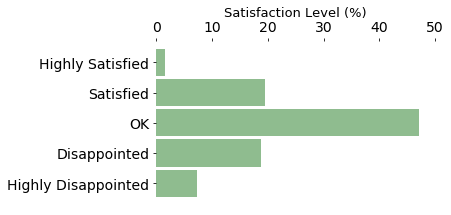

In [152]:
def likert():
    df1 = df[['Business Category', 
              '18._How_satisfied_are_you_with_the_currently_available_Internet_measurement_platforms_in_Africa_as_listed_in_the_previous_question?_1:_Highly_Disappointed;_5:_Highly_Satisfied']]
    df1.rename(columns={'18._How_satisfied_are_you_with_the_currently_available_Internet_measurement_platforms_in_Africa_as_listed_in_the_previous_question?_1:_Highly_Disappointed;_5:_Highly_Satisfied':\
                        'Likert Scale'}, inplace=True)
    
    df1.set_index('Business Category', inplace=True)
    df1.dropna(inplace=True)
    
    likert={} 
    grouped={}
    for value in df1['Likert Scale'].unique():
        option = "option_{}".format(value)
        likert[option] = df1.loc[df1['Likert Scale'] == value]
        total = likert[option].groupby(level=0).describe()['Likert Scale', 'count'].sum()
        percent = round((total/total_responses)*100, 2)
        grouped.update({option:percent})
    
    
    grouped['Highly Disappointed'] = grouped.pop('option_1')
    grouped['Disappointed'] = grouped.pop('option_2')
    grouped['OK'] = grouped.pop('option_3')
    grouped['Satisfied'] = grouped.pop('option_4')
    grouped['Highly Satisfied'] = grouped.pop('option_5')
    
    fig, ax = plt.subplots(figsize=(5,3))
    bars = plt.barh(*zip(*grouped.items()), height=.9, color='darkseagreen')
    
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.set_xlabel('Satisfaction Level (%)', fontdict={'fontsize': 13})
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.savefig('figures/likert.pdf', bbox_inches = 'tight')        
    return
likert()

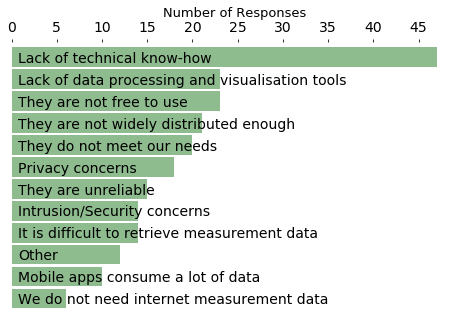

In [153]:
#Reasons for not using platforms
def not_using():
    columns = ['23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[They_do_not_meet_our_needs_(for_e.g.,_some_features_are_not_available)]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[They_are_not_widely_distributed_enough]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[They_are_unreliable]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[It_is_difficult_to_retrieve_measurement_data]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[Intrusion/Security_concerns]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[Privacy_concerns]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[They_are_not_free_to_use]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[Lack_of_data_processing_and_visualisation_tools]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[Mobile_apps_consume_a_lot_of_data]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[Lack_of_technical_know-how]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[We_do_not_need_internet_measurement_data]',
 '23._What_are_the_main_reasons_you_are_not_using_any_of_the_available_Internet_measurement_platforms_(or_are_using_but_in_a_limited_way)?_[Other]']
    
    df1 = df[columns]
    df1.replace(('Yes', 'No'), (1, 0), inplace=True)
    df1.columns = df1.columns.str.replace("_", " ")
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        df1.rename(columns={col:name}, inplace=True)
        
    df1.rename(columns={'They do not meet our needs (for e.g., some features are not available)':\
                       'They do not meet our needs'}, inplace=True)
    
    df1['Other'] = df1['Other'].notnull().astype(int) #Change text to 1 and NaN to 0
    df1.loc['Total',:]= df1.sum(axis=0)
    
    data = df1.T['Total'].sort_values()
    ax = data.plot(kind='barh', width=.9, figsize=(8,5), color='darkseagreen')
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.yaxis.tick_right()
    ax.tick_params(axis="y", which='major', length=0)
    ax.tick_params(axis="y",direction="in", pad=-440)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Number of Responses', fontdict={'fontsize': 13})
    ax.set_xticks([0,5,10,15,20,25,30,35,40,45])
    plt.savefig('figures/platforms_use.pdf', bbox_inches = 'tight')
    plt.show()
    return
not_using()

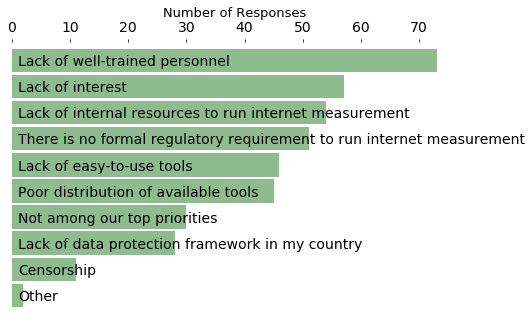

In [154]:
#Factors hindering
def not_using():
    columns = ['27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[There_is_no_formal_regulatory_requirement_to_run_internet_measurement]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Lack_of_data_protection_framework_in_my_country]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Lack_of_internal_resources_to_run_internet_measurement]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Lack_of_easy-to-use_tools]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Poor_distribution_of_available_tools]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Lack_of_interest]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Lack_of_well-trained_personnel]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Censorship]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Not_among_our_top_priorities]',
 '27._Which_of_these_factors_is_hindering_Internet_measurement_in_Africa?_(Select_as_many_as_you_think_are_applicable)_[Other]']
    
    df1 = df[columns]
    df1.replace(('Yes', 'No'), (1, 0), inplace=True)
    df1.columns = df1.columns.str.replace("_", " ")
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        df1.rename(columns={col:name}, inplace=True)
   
    df1['Other'] = df1['Other'].notnull().astype(int) #Change text to 1 and NaN to 0
    df1.loc['Total',:]= df1.sum(axis=0)
    
    data = df1.T['Total'].sort_values()
    ax = data.plot(kind='barh', width=.9, figsize=(8,5), color='darkseagreen')
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.yaxis.tick_right()
    ax.tick_params(axis="y", which='major', length=0)
    ax.tick_params(axis="y",direction="in", pad=-440)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Number of Responses', fontdict={'fontsize': 13})
    ax.set_xticks([0,10,20,30,40,50,60,70])
    plt.savefig('figures/hinder.pdf', bbox_inches = 'tight')
    plt.show()
    return 
not_using()